Importing all the modules. Some may not be needed as of now. 

In [1]:
# modules - probably too many
import numpy as np
import pandas as pd
import pickle
import matplotlib
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn import neighbors
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import matplotlib.colors as colors
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'
import math
import seaborn as sns
import multiprocessing
import numpy.matlib as npm
import geeadd
import ee
import mlLocal
from importlib import reload
import geemap

In [2]:
#code the input feature domain by using a linear hash for each row of the input data frame
#the hash algorithm converts each input row into an integer from 0 to 9 by applying the provided scale and offset and then rounding
#is then produces a hash entry for each row by packing the integers consequitively to form a uint64 code
#this implies a limit of at most 18 columns for the input data frame
#returns a list corresonding to hash table of unique coded input rows
def makeDomain(df,domainIndex,domainScaling,domainOffset):
    df = np.array(df) 
    if df.shape[1] < 19 :
        domainIndex = np.array(domainIndex)
        domainScaling = np.array(domainScaling)
        domainOffset = np.array(domainOffset)
    else:
        raise ValueError("More than 18 dimensions in domain")
    return np.uint64(np.unique(np.sum(np.clip(np.around(df* domainScaling + domainOffset,0),0,9) * np.power(10,np.cumsum(domainIndex)-domainIndex[0]),1),0)).tolist()
          

In [3]:
def trainClassifier(dataDict,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset,samplingFeatures=None,minSubSamples=2000,minSatSamples=-1,maxSamples=10000,percentilePairwiseDist=99,maxleafnodesParent= 1, minSamplesLeafParent=100, maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures="auto",nTrees = 100):
    
    
    # make generic names for regressors for use in GEE
    regressors = []
    for item in np.arange(1,len(regressorsNames)+1,1):
        regressors.append('x' + str(item))

    # Calibrate hierarchal randforest preeidctors for each biome
    for biome in dataDict.keys():
        print('biome:',biome)

        if ( biome <10):
            # subset only the regressors and response 
            dfBiome = dataDict[biome]['DF'][sum([regressorsNames,response],[])].astype('int')

            
            # resample the data for calibrating parent tree
            if ( samplingFeatures != None ) :
                dfParent = resampleDF(dfBiome ,regressorsNames,samplingFeatures,minSubSamples=minSubSamples,minSatSamples=minSatSamples,maxSamples=maxSamples,percentilePairwiseDist=percentilePairwiseDist)
                print('subsampled',dfParent.shape)

                dfParent = resampleDF(dfParent,regressorsName,features,minSubSamples,minSubSamples=minSubSamples,minSatSamples=minSatSamples,maxSamples=maxSamples,percentilePairwiseDist=50)
            else :
                dfParent = dfBiome
                
            dfBiome.columns = sum([regressors,response],[])
            dfParent.columns = sum([regressors,response],[])
            print(dfBiome.shape)
            print(dfParent.shape)
             # populate a parent RF dictionary that holds a single tree RF used to partition data into child RFs
            parentRFDict = {}
            parentRFDict.update({'regressors': regressors})
            parentRFDict.update({'regressorsGEE': regressorsGEENames})
            parentRFDict.update({'response': response})
            parentRFDict.update({'domain':makeDomain(dfBiome[regressors],domainIndex,domainScaling,domainOffset)})
            parentRFDict.update({'RF': RandomForestRegressor(n_estimators=1,min_samples_leaf=minSamplesLeafParent,min_samples_split=int(dfParent.shape[0]*0.1),bootstrap=False,random_state=0,verbose=0,max_depth=10,max_leaf_nodes=maxleafnodesParent,max_features=maxFeatures,n_jobs=40) \
                                                                                                         .fit(dfParent[regressors], np.array(dfParent[response]).ravel())})       
            
            # label input data using the prediction from the parent RF as this will be unique
            dfBiome['estimate']=np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)

            # populate dictionary of children RFs, each childRF is itself a dictionary similar to the parentRF but now using more than one tree
            # each child is labelled using the prediction value from the parentRF corresponding to its partition
            childrenRFDict = {}
            print('number children:',np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)).size)
            for partition in np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)):
                dfpartitionBiome = dfBiome.loc[dfBiome['estimate'] == partition]
                childRFDict = {}
                childRFDict.update({'size': dfpartitionBiome[response].shape[0]})
                childRFDict.update({'regressors': regressors})
                childRFDict.update({'regressorsGEE': regressorsGEENames})
                childRFDict.update({'response': response})
                childRFDict.update({'domain':makeDomain(dfpartitionBiome[regressors],domainIndex,domainScaling,domainOffset)})
                childRFDict.update({'RF': RandomForestRegressor(n_estimators=nTrees,min_samples_leaf=minSamplesLeafChild,bootstrap=True,random_state=0,verbose=0,max_depth=9,max_leaf_nodes=maxleafnodesChild,max_features=maxFeatures,n_jobs=40) \
                                         .fit(dfpartitionBiome[regressors], np.array(dfpartitionBiome[response]).ravel())})             
                childrenRFDict.update({partition: childRFDict})

            # assign the childrenRFDict to the parent
            parentRFDict.update({'childrenRFDict':childrenRFDict })      

            #assign the parentRF dict to the calibration data dictionary for trhis biome
            dataDict[biome].update({method+response[0]+'parentRFDict':parentRFDict})   
    return dataDict

In [4]:
# apply algorithm to data 
def predictClassifier(dataDict,methodDict, method, regressorsNames, response):
    # make generic names for regressors for use in GEE
    regressors = []
    for item in np.arange(1,len(regressorsNames)+1,1):
        regressors.append('x' + str(item))

    # Calibrate hierarchal randforest preeidctors for each biome
    for biome in dataDict.keys():
        print('biome:',biome)

        if ( biome <9):
            # subset only the regressors 
            dfBiome = dataDict[biome]['DF'][sum([regressorsNames],[])].astype('int')
            dfBiome.columns = regressors

            #apply the parent classifier
            parentRF = methodDict[biome][method+response[0]+'parentRFDict']['RF']
            dfBiome['childNames'] =  np.around(parentRF.predict(dfBiome),decimals=3)
            dataDict[biome]['DF'][method + response[0]+'childNames'] =dfBiome['childNames']

            for partition in np.unique(dfBiome['childNames'] ):
                dfBiome.loc[dfBiome['childNames']==partition,method + response[0]] = methodDict[biome][method+response[0]+'parentRFDict']['childrenRFDict'][partition]['RF'].predict(dfBiome.loc[dfBiome['childNames']==partition][regressors])  
            dataDict[biome]['DF'][method + response[0]] = dfBiome[method + response[0]]
           
    return dataDict

In [5]:
def hierarchicalRF(dataDictParent,dataDictChild,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=20, minSamplesSplit=11,maxleafnodesParent= 100, minSamplesLeafParent=10, maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures="auto",nTrees = 100):
    
    
    # make generic names for regressors for use in GEE
    regressors = []
    for item in np.arange(1,len(regressorsNames)+1,1):
        regressors.append('x' + str(item))

    # Calibrate hierarchal randforest preeidctors for each biome
    for biome in dataDictParent.keys():
        print('biome:',biome)

        # subset only the regressors and response 
        dfBiome = dataDictChild[biome]['DF'][sum([regressorsNames,response],[])].astype('int')   
        dfParent = dataDictParent[biome]['DF'][sum([regressorsNames,response],[])].astype('int')


        dfBiome.columns = sum([regressors,response],[])
        dfParent.columns = sum([regressors,response],[])
        print('Total size ',dfBiome.shape)
        print('Parent size ',dfParent.shape)
         # populate a parent RF dictionary that holds a single tree RF used to partition data into child RFs
        parentRFDict = {}
        parentRFDict.update({'regressors': regressors})
        parentRFDict.update({'regressorsGEE': regressorsGEENames})
        parentRFDict.update({'response': response})
        parentRFDict.update({'domain':makeDomain(dfBiome[regressors],domainIndex,domainScaling,domainOffset)})
        parentRFDict.update({'RF': RandomForestRegressor(n_estimators=1,min_samples_leaf=minSamplesLeafParent,min_samples_split=minSamplesSplit,bootstrap=False,random_state=0,verbose=0,max_depth=maxDepth,max_leaf_nodes=maxleafnodesParent,max_features=maxFeatures,n_jobs=40) \
                                                                                                         .fit(dfParent[regressors], np.array(dfParent[response]).ravel())})         
        # label input data using the prediction from the parent RF as this will be unique
        dfBiome['estimate']=np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)

        # populate dictionary of children RFs, each childRF is itself a dictionary similar to the parentRF but now using more than one tree
        # each child is labelled using the prediction value from the parentRF corresponding to its partition
        childrenRFDict = {}
        print('number children:',np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)).size)
        for partition in np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)):
            dfpartitionBiome = dfBiome.loc[dfBiome['estimate'] == partition]
            childRFDict = {}
            childRFDict.update({'size': dfpartitionBiome[response].shape[0]})
            childRFDict.update({'regressors': regressors})
            childRFDict.update({'regressorsGEE': regressorsGEENames})
            childRFDict.update({'response': response})
            childRFDict.update({'domain':makeDomain(dfpartitionBiome[regressors],domainIndex,domainScaling,domainOffset)})
            childRFDict.update({'RF': RandomForestRegressor(n_estimators=nTrees,min_samples_leaf=minSamplesLeafChild,bootstrap=True,random_state=0,verbose=0,max_depth=9,max_leaf_nodes=maxleafnodesChild,max_features=maxFeatures,n_jobs=40) \
                                     .fit(dfpartitionBiome[regressors], np.array(dfpartitionBiome[response]).ravel())})             
            childrenRFDict.update({partition: childRFDict})

        # assign the childrenRFDict to the parent
        parentRFDict.update({'childrenRFDict':childrenRFDict })      

        #assign the parentRF dict to the calibration data dictionary for trhis biome
        dataDictParent[biome].update({method+response[0]+'parentRFDict':parentRFDict})   
    return dataDictParent

In [6]:
# histogram plot of values and density for LAI and fAPAR for a biome and save to file

def histplotKDE(biome,outputFileName=None) :
    sns.set_context("paper")
    df1 = calbiomeDictLAI[biome]['DF'][['LAI','kde']].sample(np.min([1000,calbiomeDictLAI[biome]['DF'].shape[0]])).divide([10.,1.])
    df2 = valbiomeDictLAI[biome]['DF'][['LAI','kde']].sample(np.min([1000,valbiomeDictLAI[biome]['DF'].shape[0]])).divide([10.,1.])
    df3 = calbiomeDictFAPAR[biome]['DF'][['FAPAR','kde']].sample(np.min([1000,calbiomeDictFAPAR[biome]['DF'].shape[0]])).divide([10.,1.])
    df4 = valbiomeDictFAPAR[biome]['DF'][['FAPAR','kde']].sample(np.min([1000,valbiomeDictFAPAR[biome]['DF'].shape[0]])).divide([10.,1.])

    fig, axs = plt.subplots(ncols=2,nrows=2 , figsize=(7, 4))
    fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
    ax = axs[0,0]
    hb = sns.histplot(df1,x='LAI',ax=ax, fill=False, element="step",stat='probability')
    hb = sns.histplot(df2,x='LAI',ax=ax, fill=False, element="step",stat='probability')
    ax = axs[0,1]
    hb = sns.histplot(df1,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    hb = sns.histplot(df2,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    ax = axs[1,0]
    hb = sns.histplot(df3,x='FAPAR',ax=ax, fill=False, element="step",stat='probability')
    hb = sns.histplot(df4,x='FAPAR',ax=ax, fill=False, element="step",stat='probability')
    ax = axs[1,1]
    hb = sns.histplot(df3,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    hb = sns.histplot(df4,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    plt.show()
    if (outputFileName != None):
        fig.savefig(outputFileName, bbox_inches='tight') 
    return

In [7]:
# does pair plots of densities for each method for a biome
def pairplotKDE(biome,outputFileName=None):
    df1 = calbiomeDictLAI[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kde']].sample(np.min([1000,calbiomeDictLAI[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    df2 = calbiomeDictLAIFTL[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kde']].sample(np.min([1000,calbiomeDictLAIFTL[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    df3 = calbiomeDictLAIKANG[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kde']].sample(np.min([1000,calbiomeDictLAIKANG[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    df4 = calbiomeDictLAIFTLX2[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kde']].sample(np.min([1000,calbiomeDictLAIFTLX2[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
 
    hue1 = df1['kde'].divide(df1['kde'].median())
    hue2 = df2['kde'].divide(df2['kde'].median())
    hue3 = df3['kde'].divide(df3['kde'].median())
    hue4 = df4['kde'].divide(df2['kde'].median())

    # hue123 = np.array(pd.DataFrame([hue1,hue2,hue3,hue4]))
    hueNorm = (0,2) # (np.percentile(hue123,0.05),np.percentile(hue123,95))
    
    fig, axs = plt.subplots(ncols=4,nrows=2 , figsize=(12, 8),sharey='row',sharex= 'row')
    fig.subplots_adjust(hspace=0.2, left=0.07, right=0.93)
    ax =  axs[0,0]
    hb = sns.scatterplot(x=df1['LAI'],y=df1['FAPAR'],hue=df1['kde'].divide(df1['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[0,1]
    hb = sns.scatterplot(x=df2['LAI'],y=df2['FAPAR'],hue=df2['kde'].divide(df2['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[0,2]
    hb = sns.scatterplot(x=df3['LAI'],y=df3['FAPAR'],hue=df3['kde'].divide(df3['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[0,3]
    hb = sns.scatterplot(x=df4['LAI'],y=df4['FAPAR'],hue=df4['kde'].divide(df4['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[1,0]
    hb = sns.scatterplot(x=df1['red'],y=df1['NIR'],hue=df1['kde'].divide(df1['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[1,1]
    hb = sns.scatterplot(x=df2['red'],y=df2['NIR'],hue=df2['kde'].divide(df2['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[1,2]
    hb = sns.scatterplot(x=df3['red'],y=df3['NIR'],hue=df3['kde'].divide(df3['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[1,3]
    hb = sns.scatterplot(x=df4['red'],y=df4['NIR'],hue=df4['kde'].divide(df4['kde'].median()),hue_norm=hueNorm,ax=ax)
    if ( outputFileName != None ) :
        fig.savefig(outputFileName, bbox_inches='tight') 
    return

In [8]:
# plots hoistograms of all estimators for raw bands and augmented bands
def plotHistResultsCond(df,xname,yname,datarange,nbins,gamma):
    fig, ax0 = plt.subplots(figsize=(8,8))    
    predictions = np.array(df[xname])
    targets = np.array(df[yname])    
    print(np.sqrt(np.mean((predictions-targets)**2)))
    condHist = (np.histogram2d(targets,predictions, bins=nbins, range=datarange, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax0.plot(x, 0*y, color="white", linewidth=1)
    f1=ax0.imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma=gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax0,fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax0.plot(xvalues, res ,'w.', label='Mean Value') 
    # unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    # ax0.plot(xvalues, unc ,'r.', label='Uncertainty')  
    ax0.plot(datarange[0],datarange[1],"w",label='1:1 Line')

In [9]:
# plots hoistograms of all estimators for raw bands and augmented bands
def plotHistResidualsCond(df,xname,yname,datarange,nbins,gamma):
    fig, ax0 = plt.subplots(figsize=(8,8))

    
    predictions = np.array(df[xname])
    targets = np.array(df[yname])
    condHist = (np.histogram2d(targets,predictions-targets, bins=nbins, range=datarange, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0001)
    ax0.plot(x, 0*y, color="white", linewidth=1)
    f1=ax0.imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma=gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax0,fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax0.plot(xvalues, res ,'w.', label='Accuracy') 
    unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    ax0.plot(xvalues, unc ,'r.', label='Uncertainty')  
    # pre = np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)) - np.matlib.repmat(np.flipud(res),dataHist.shape[1],1)
    # ax0.plot(xvalues, pre ,'y.', label='Uncertainty')  

In [10]:
# parse a sckitlearn decision tree into a R text tree suitable for use in GEE
# for compactness ancillary items like node sample size and residuals are forced to = 1
# this is a blind guess by Richard but seems to work
def make_tree(rf,regressors,decimals):
    
    # first get the output in sckitlearn text format in a dataframe
    r = export_text(rf,feature_names=regressors,show_weights=True,decimals=decimals)
    r = r.splitlines()
    rdf = pd.DataFrame(r,columns = ['rule'])

    #identify rules and not leaf values
    isrule = ~rdf['rule'].str.contains('value')
    rulesdf = rdf.loc[isrule]

    #determine level in tree and the associated starting based node number
    rdf['level'] = rdf['rule'].str.count(r'(\|)').values.tolist()
    rdf.loc[isrule,'base'] = ((rdf.level).mul(0).add(2)).pow(rdf.level)

    # get the actual tested condition
    rdf.loc[isrule,'condition'] =  rdf.loc[isrule,'rule'].str.extract(r'(x.+)').values.tolist()
    
    # identify leaf nodes and fill in the response value
    rdf.loc[~isrule,'leaf'] = '*'
    rdf['leaf'] = rdf['leaf'].fillna(method='bfill',limit=1)
    rdf.loc[~isrule,'response'] = rdf.loc[~isrule,'rule'].str.extract(r'([+-]?([0-9]*[.])?[0-9]+)')[0].values.tolist()
    rdf['response'] = rdf['response'].fillna(method='bfill')
    
    #check size of tree 
    if rdf.shape[0]==1:
    #
    # There is only one value and no splits
    # # force a tree with one split where both leaf nodes have same value
    # parse the root node and get the respose value
        response = rdf['response'][0]
        return ( '1) root 1 1 1 (1)\n  2) x1 <= 0.000 0 0 ' + response + ' *\n  3) x1 >  0.000 0 0 ' + response + ' *\n')
    else:
        #discard non rules
        rdf.loc[rdf['leaf'].isna(),'leaf'] = ' '
        rdf = rdf.dropna()

        #dtermine if this is a left or right branch
        rdf['branch'] = rdf['rule'].str.contains(r'(?:\>)').astype('int')
        rdf['node'] = rdf.base + rdf.branch
        rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
        rdfindex = rdf.index
        
    #asign a node number, this is non trivial and critical for use later
    #read https://www.r-bloggers.com/2022/10/understanding-leaf-node-numbers-when-using-rpart-and-rpart-rules/
        for row in range(2,rdf.shape[0]):
            # find the nearest row above
            df = rdf[0:row]
            if ( (rdf[row:row+1].level.values)[0] > 1 ):
                parentdf = df.loc[df.level == (rdf[row:row+1].level.values-1)[0]].iloc[-1]
                rdf.at[rdfindex[row],'parentbase'] = parentdf.base  
                rdf.at[rdfindex[row],'parentnode'] = parentdf.node  
                rdf.at[rdfindex[row],'node'] = rdf.iloc[row].node + 2 * (  parentdf.node - parentdf.base ) 

        # glue together each rule in a big string, add the root node and return as a list
        rdf['phrase'] = rdf.apply(lambda x:  ' ' *(2 * x.level) + str(int(x.node)) + ') ' \
                                  + x.condition + ' 0 0 ' + str(x.response) + ' ' +x.leaf + '\n', axis=1)
        return ( '1) root 1 1 1 (1)\n'+''.join(rdf['phrase'].values.tolist()))

Reading in all calibration data.

In [11]:
dfALL = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/MODISLANDSATall.pkl')
dfALLtrim = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/MODISLANDSATalltrim.pkl')
dfALLtrimKANG = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/MODISLANDSATalltrimKANG.pkl')

In [12]:
# Validation data for LAI and FAPAR
valbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/valbiomeDictLAI.pkl')
valbiomeDictFAPAR = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/valbiomeDictFAPAR.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictLAI.pkl')
calbiomeDictFAPAR = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictFAPAR.pkl')

# Kang's calibration data for LAI and FAPAR
calbiomeDictLAIKANG = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictLAIKANG.pkl')
calbiomeDictFAPARKANG = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictFAPARKANG.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAIFTL = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictLAIFTL.pkl')
calbiomeDictFAPARFTL = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictFAPARFTL.pkl')

# https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

In [ ]:
# RF - Cassidy please make separate plots like Fig 7 of K2021 for LAI and fAPAR from calbiomeDictLAIKANG and calbiomeDictFAPARKANG BUT with one change
#       Add a second series of histograms on the plot corresponding to the NAIVE database from calbiomeDictLAI and calbiomeDictFAPAR using only kde (it will show lines) and no boxes
# usen histplot with **kwargs to control transparence and kde to make line fits to histograms

In [ ]:
#NAIVE LAI
method='NAIVE'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'
valbiomeDFLAI = pd.DataFrame()
for LC_type3 in calbiomeDictLAI.keys():
    df = calbiomeDictLAI[LC_type3]['DF']
    calbiomeDictLAI[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAI[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3][method+response+'regression'] = calbiomeDictLAI[LC_type3][method+response+'regression']
    valbiomeDictLAI[LC_type3]['DF'][method+response] = valbiomeDictLAI[LC_type3][method+response+'regression'].predict(valbiomeDictLAI[LC_type3]['DF'][regressors])
    valbiomeDFLAI = pd.concat([valbiomeDFLAI,valbiomeDictLAI[LC_type3]['DF']])
sns.scatterplot(valbiomeDFLAI.sample(10000),y=response,x=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFLAI,method+response,response,datarange=[[0,70],[0,70]],nbins=70,gamma=0.5)
plotHistResidualsCond(valbiomeDFLAI,method+response,response,datarange=[[0,70],[-25,25]],nbins=70,gamma=0.5)

In [ ]:
#NAIVE FAPAR
method='NAIVE'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'FAPAR'
valbiomeDFFAPAR = pd.DataFrame()
for LC_type3 in calbiomeDictFAPAR.keys():
    df = calbiomeDictFAPAR[LC_type3]['DF']
    calbiomeDictFAPAR[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPAR[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictFAPAR[LC_type3][method+response+'regression'] = calbiomeDictFAPAR[LC_type3][method+response+'regression']
    valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPAR[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])
    valbiomeDFFAPAR = pd.concat([valbiomeDFFAPAR,valbiomeDictFAPAR[LC_type3]['DF']])
sns.scatterplot(valbiomeDFFAPAR.sample(10000),y=response,x=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFFAPAR,method+response,response,datarange=[[0,100],[0,100]],nbins=70,gamma=0.5)
plotHistResidualsCond(valbiomeDFFAPAR,method+response,response,datarange=[[0,100],[-25,25]],nbins=70,gamma=0.5)


In [ ]:
#K2021 LAI
method='KANG'
regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
response = 'LAI'
valbiomeDFLAI = pd.DataFrame()
for LC_type3 in calbiomeDictLAIKANG.keys():
    df = calbiomeDictLAIKANG[LC_type3]['DF']
    calbiomeDictLAIKANG[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=50,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAIKANG[LC_type3]['DF'][method+response] = calbiomeDictLAIKANG[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3][method+response+'regression'] = calbiomeDictLAIKANG[LC_type3][method+response+'regression']
    valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAIKANG[LC_type3][method+response+'regression'].predict(valbiomeDictLAI[LC_type3]['DF'][regressors])
    valbiomeDFLAI = pd.concat([valbiomeDFLAI,valbiomeDictLAI[LC_type3]['DF']])
sns.scatterplot(valbiomeDFLAI.sample(10000),y=response,x=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFLAI,method+response,response,datarange=[[0,70],[0,70]],nbins=70,gamma=0.5)
plotHistResidualsCond(valbiomeDFLAI,method+response,response,datarange=[[0,70],[-25,25]],nbins=70,gamma=0.5)

In [ ]:
# K2021 FAPAR
regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
response = 'FAPAR'
valbiomeDFFAPAR = pd.DataFrame()
for LC_type3 in calbiomeDictFAPARKANG.keys():
    df = calbiomeDictFAPARKANG[LC_type3]['DF']
    calbiomeDictFAPARKANG[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=50,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictFAPARKANG[LC_type3]['DF'][method+response] = calbiomeDictFAPARKANG[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictFAPAR[LC_type3][method+response+'regression'] = calbiomeDictFAPARKANG[LC_type3][method+response+'regression']
    valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARKANG[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])
    valbiomeDFFAPAR = pd.concat([valbiomeDFFAPAR,valbiomeDictFAPAR[LC_type3]['DF']])
sns.scatterplot(valbiomeDFFAPAR.sample(10000),y=response,x=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFFAPAR,method+response,response,datarange=[[0,100],[0,100]],nbins=70,gamma=0.5)
plotHistResidualsCond(valbiomeDFFAPAR,method+response,response,datarange=[[0,100],[-25,25]],nbins=70,gamma=0.5)

biome: 2
Total size  (484803, 6)
Parent size  (12307, 6)
number children: 384
biome: 1
Total size  (2358489, 6)
Parent size  (50839, 6)
number children: 685
biome: 9
Total size  (19139, 6)
Parent size  (3494, 6)
number children: 61
biome: 4
Total size  (1767953, 6)
Parent size  (10138, 6)
number children: 408
biome: 6
Total size  (541659, 6)
Parent size  (4251, 6)
number children: 259
biome: 7
Total size  (376649, 6)
Parent size  (3273, 6)
number children: 201
biome: 8
Total size  (60520, 6)
Parent size  (4469, 6)
number children: 238
biome: 3
Total size  (260190, 6)
Parent size  (5322, 6)
number children: 234
biome: 5
Total size  (215478, 6)
Parent size  (4363, 6)
number children: 230
biome: 10
Total size  (2208, 6)
Parent size  (2208, 6)
number children: 144
biome: 2
biome: 1
biome: 9
biome: 4
biome: 6
biome: 7
biome: 8
biome: 3
biome: 5
biome: 10
biome: 2
biome: 1
biome: 9
biome: 4
biome: 6
biome: 7
biome: 8
biome: 3
biome: 5
biome: 10
nan


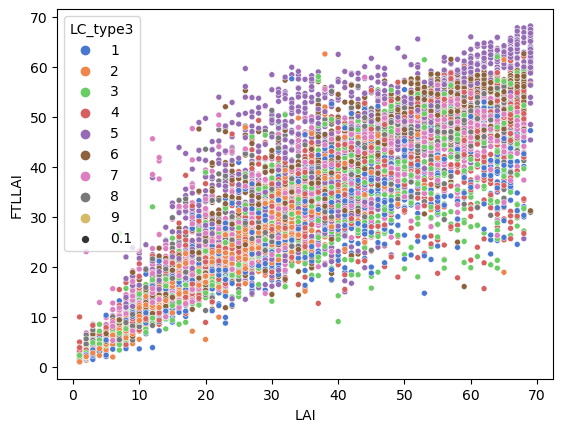

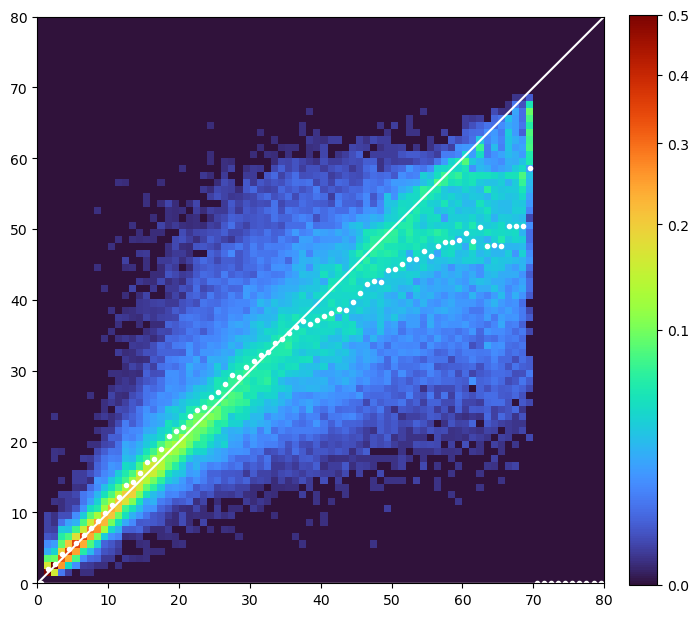

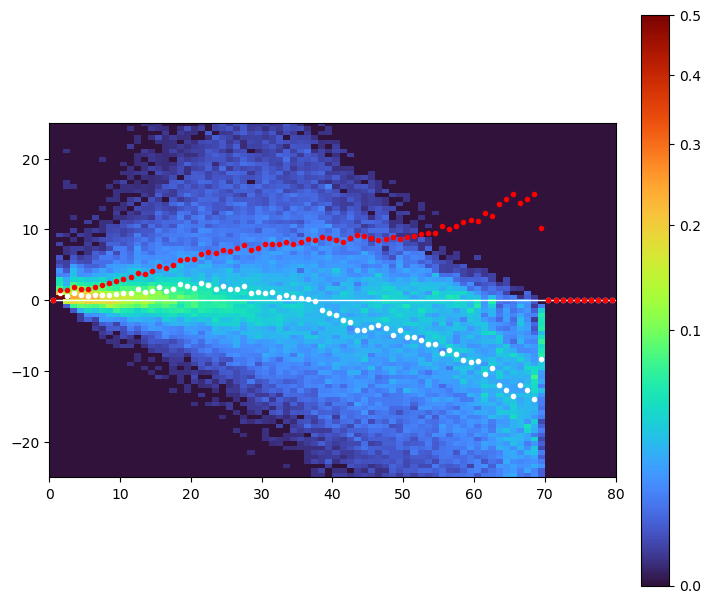

In [13]:
# FTL LAI
# try this with small RF and then uncomment out the 28-29 and comment line 25-26
method = 'FTL'

# response variable name
response = ['LAI']

# Regressor Names
# Names within scope of this script
regressorsNames = ['red','NIR','cosSZA','cosVZA','cosSA']
samplingFeatures = regressorsNames
# Names within scope of GEE
regressorsGEENames =  [ 'SR_B4', 'SR_B5','cosSZA','cosVZA','cosSA'] 
# Generic names we export RF with
regressors = ["x1","x2","x3","x4","x5"]

#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 10/10000, 10/10000,10/10000,10/10000,10/10000]
# Offset per regressor
domainOffset = [ 0,0,0,0,0]

# calbiomeDictLAIFTL= hierarchicalRF(calbiomeDictLAIFTL,calbiomeDictLAI,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=10, minSamplesSplit=11,\
#                              maxleafnodesParent=10,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures=5,nTrees = 10)

calbiomeDictLAIFTL= hierarchicalRF(calbiomeDictLAIFTL,calbiomeDictLAI,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=10, minSamplesSplit=11,\
                             maxleafnodesParent=999,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures=5,nTrees = 100)

calbiomeDictLAIFTL=  predictClassifier(calbiomeDictLAIFTL,calbiomeDictLAIFTL, 'FTL', regressorsNames, ['LAI'])
valbiomeDictLAI=  predictClassifier(valbiomeDictLAI,calbiomeDictLAIFTL, 'FTL', regressorsNames, ['LAI'])


method = 'FTL'
response = 'LAI'
valbiomeDFLAI = pd.DataFrame()
for LC_type3 in calbiomeDictLAI.keys():
    if ( LC_type3<10) :
        valbiomeDFLAI = pd.concat([valbiomeDFLAI,valbiomeDictLAI[LC_type3]['DF']])
sns.scatterplot(valbiomeDFLAI.sample(10000),x=response,y=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFLAI,method+response,'LAI',datarange=[[0,80],[0,80]],nbins=80,gamma=0.5)
plotHistResidualsCond(valbiomeDFLAI,method+response,'LAI',datarange=[[0,80],[-25,25]],nbins=80,gamma=0.5)

In [ ]:
print(calbiomeDictLAIFTL[1]['FTLLAIparentRFDict']['RF'])

In [ ]:
# FTL FAPAR
method = 'FTL'

# response variable name
response = ['FAPAR']

# Regressor Names
# Names within scope of this script
regressorsNames = ['red','NIR','cosSZA','cosVZA','cosSA']
samplingFeatures = regressorsNames
# Names within scope of GEE
regressorsGEENames =  [ 'SR_B4', 'SR_B5','cosSZA','cosVZA','cosSA'] 
# Generic names we export RF with
regressors = ["x1","x2","x3","x4","x5"]

#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 10/10000, 10/10000,10/10000,10/10000,10/10000]
# Offset per regressor
domainOffset = [ 0,0,0,0,0]

calbiomeDictFAPARFTL= hierarchicalRF(calbiomeDictFAPARFTL,calbiomeDictLAI,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=10, minSamplesSplit=11,\
                             maxleafnodesParent=999 ,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures=5,nTrees = 100)


calbiomeDictFAPARFTL=  predictClassifier(calbiomeDictFAPARFTL,calbiomeDictFAPARFTL, 'FTL', regressorsNames, ['FAPAR'])
valbiomeDictFAPAR=  predictClassifier(valbiomeDictLAI,calbiomeDictFAPARFTL, 'FTL', regressorsNames, ['FAPAR'])


method = 'FTL'
response = 'FAPAR'
valbiomeDFFAPAR = pd.DataFrame()
for LC_type3 in calbiomeDictFAPAR.keys():
    if ( LC_type3<10) :
        valbiomeDFFAPAR = pd.concat([valbiomeDFFAPAR,valbiomeDictFAPAR[LC_type3]['DF']])
sns.scatterplot(valbiomeDFFAPAR.sample(10000),x=response,y=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFFAPAR,method+response,'FAPAR',datarange=[[0,80],[0,80]],nbins=80,gamma=0.5)
plotHistResidualsCond(valbiomeDFFAPAR,method+response,'FAPAR',datarange=[[0,80],[-25,25]],nbins=80,gamma=0.5)

In [ ]:
# Cassidy - please make plots like fig 8 of K2021 but in stead of all and correctly classified series you will need a separate series for each method
# Once you make the plots for LAI repeat for FAPAR

In [15]:
ee.Authenticate()

Enter verification code:  4/1AWtgzh7j7PRkOjpsA6G-g0dkjp_feAsZjY1lSZoCjPOADHucY8at0Q5wtVA



Successfully saved authorization token.


In [16]:
ee.Initialize()

In [17]:
print(geemap.ee_user_id() )

users/ccrs11fy2022li


In [ ]:
# upload FTL classiers to gee as feature collections
reload(mlLocal)

method = 'FTL'

# response variable name
response = ['LAI']
targetDirectory = '/FTL_LAI_trees/'
methodDict = calbiomeDictLAIFTL

# Scaling and offset required of GEE regressors
regressorsGEECollectionName= "LANDSAT/LC08/C02/T1_L2"
regressorsGEEScaling = [2.75e-05,2.75e-05,1,1,1]
regressorsGEEOffset = [-0.02,-0.02,0,0,0]
regressorsGEEScaling2 = [10000,10000,10000,10000,10000]
responseGEEScaling = [1]
responseGEEOffset = [0]

for biome in [1,2,3,4,5,6,7,8]:
    print('biome', biome)
    parentRFDict = methodDict[biome][method+response[0]+'parentRFDict']
    domain = parentRFDict['domain']
    trees = []
    trees.append(make_tree(parentRFDict['RF'][0],regressors,3))
    # print(trees[0])
    print('# of children', len(parentRFDict['childrenRFDict']))
    assetID = geemap.ee_user_id() + targetDirectory + method + 'biome' + str(biome) + 'parentRF' 
    mlLocal.export_trees_to_fc_CCRS(trees,response,regressors,regressorsGEECollectionName,regressorsGEENames,responseGEEScaling,responseGEEOffset,regressorsGEEScaling2,regressorsGEEScaling,regressorsGEEOffset,domain,domainScaling,domainOffset,assetID)
    # ml.export_trees_to_fc(trees,assetID)
    # ee_classifier = ml.strings_to_classifier(trees)
    # print(ee_classifier.getInfo())

    childSize = []
    for partition in parentRFDict['childrenRFDict'].keys():
        print('child #', partition)
        childRFDict = parentRFDict['childrenRFDict'][partition]
        childSize.append(childRFDict['size'])

        trees = []
        for tree in np.squeeze(childRFDict['RF'].estimators_) :
            # print('child tree',tree)
            trees.append(make_tree(tree,regressors,3))
        # print(trees)
        # trees = ml.rf_to_strings(estimator=childRFDict['RF'], feature_names=regressors,processes=36,output_mode='REGRESSION')
        # CL - rounding partition to match child name to parent LAI value
        assetID = geemap.ee_user_id() + targetDirectory + method + 'biome' + str(biome) + 'childRF' + str(int(round(partition*1000, 0)))  
        domain = [0]
        domainScaling = [0]
        domainOffset = [0]
        mlLocal.export_trees_to_fc_CCRS(trees,response,regressors,regressorsGEECollectionName,regressorsGEENames,responseGEEScaling,responseGEEOffset,regressorsGEEScaling2,regressorsGEEScaling,regressorsGEEOffset,domain,domainScaling,domainOffset,assetID)
        # ml.export_trees_to_fc(trees,assetID)
        # ee_classifier = ml.strings_to_classifier(trees)
        # print(ee_classifier.getInfo())
    print(childSize)